In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from lightfm import LightFM
from lightfm.data import Dataset
from lightfm.evaluation import auc_score, precision_at_k

## Загрузка и анализ

In [2]:
base_path = '../input/sbermarket-internship-competition/'
train = pd.read_csv(base_path + 'train.csv', parse_dates=[1])
sample = pd.read_csv(base_path + 'sample_submission.csv')

In [3]:
display(train.head())
display(sample.head())

,user_id,order_completed_at,cart
0,2,2015-03-22 09:25:46,399
1,2,2015-03-22 09:25:46,14
2,2,2015-03-22 09:25:46,198
3,2,2015-03-22 09:25:46,88
4,2,2015-03-22 09:25:46,157


,id,target
0,0;133,0
1,0;5,1
2,0;10,0
3,0;396,1
4,0;14,0


In [4]:
# Разбиение данных из сабмита на отдельные переменные
users = []
items = []

for row in sample.to_numpy():
    user, item = map(int, row[0].split(';'))
    users.append(user)
    items.append(item)
    
users = np.array(users)    
items = np.array(items) 
users_set = list(set(users))
items_set = list(set(items))

In [5]:
# Анализ количества пользователей в выборках
print(f'Кол-во пользователей в тренировочной выборке: {train.user_id.nunique()}')
print(f'Кол-во пользователей в сабмите:               {len(users_set)}')

Кол-во пользователей в тренировочной выборке: 20000
Кол-во пользователей в сабмите:               13036


In [6]:
# Анализ категорий товаров
print(f'Кол-во категорий в тренировочной выборке: {train.cart.nunique()}, диапазон: {min(train.cart)}-{max(train.cart)}')
print(f'Кол-во категорий в сабмите:               {len(items_set)}, диапазон: {min(items_set)}-{max(items_set)}')

Кол-во категорий в тренировочной выборке: 881, диапазон: 0-880
Кол-во категорий в сабмите:               858, диапазон: 0-880


Видно, что в сабмите отсутствуют как пользователи, так и некоторые категории, присутствующие в тренировочной выборке.  
Их нужно будет удалить.

Минимальное кол-во заказов одного пользователя:  3
Максимальное кол-во заказов одного пользователя: 213


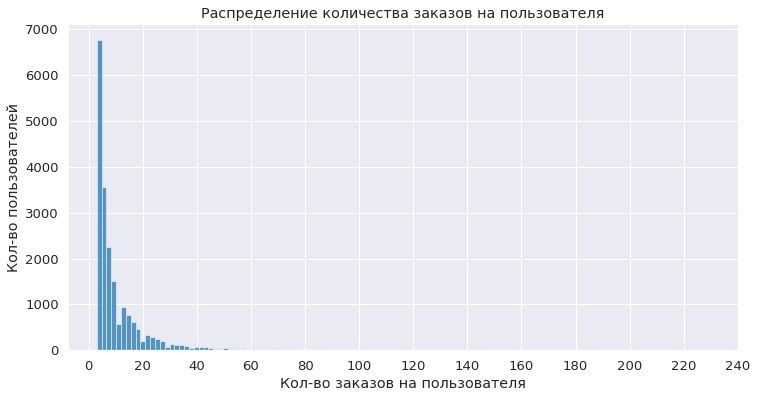

In [7]:
sns.set(style='darkgrid', palette='tab10', font_scale=1.2)

# Анализ общего числа заказов на каждого клиента
user_orders = train.groupby('user_id')['order_completed_at'].nunique()
print(f'Минимальное кол-во заказов одного пользователя:  {user_orders.min()}')
print(f'Максимальное кол-во заказов одного пользователя: {user_orders.max()}')

# Вывод распределения заказов
plt.figure(figsize=(12, 6))
sns.histplot(user_orders, bins=user_orders.nunique())
plt.xticks(range(0, 250, 20))
plt.xlabel('Кол-во заказов на пользователя')
plt.ylabel('Кол-во пользователей')
plt.title('Распределение количества заказов на пользователя');

Из распределения можно сделать вывод, что большая часть клиентов не спешит делать повторные заказы - основная масса сделала не больше 10 заказов.

Минимальное кол-во заказов одной категории:  1
Максимальное кол-во заказов одной категории: 108518


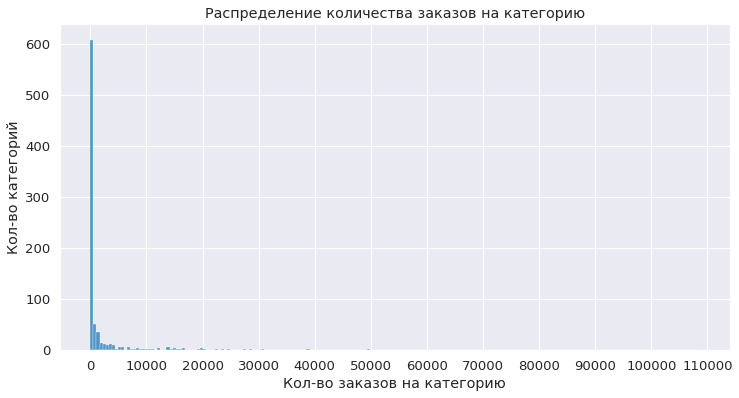

In [8]:
# Анализ заказов по категориям
cart_orders = train.groupby('cart')['order_completed_at'].nunique()
print(f'Минимальное кол-во заказов одной категории:  {cart_orders.min()}')
print(f'Максимальное кол-во заказов одной категории: {cart_orders.max()}')

# Вывод распределения заказов
plt.figure(figsize=(12, 6))
sns.histplot(cart_orders, bins=200)
plt.xticks(range(0, 120000, 10000))
plt.xlabel('Кол-во заказов на категорию')
plt.ylabel('Кол-во категорий')
plt.title('Распределение количества заказов на категорию');

Распределение продаж по категориям так же имеет сильное смещение - большая часть категорий заказывается меньше 5 тысяч раз.

## Предобработка

In [9]:
# Удаление отсутствующих категорий и пользователей
train = train.loc[train['cart'].isin(items)]
train = train.loc[train['user_id'].isin(users)]

Для сплита на тренировочную и валидационную выборку использую последние заказы каждого пользователя.

In [10]:
# Создание валидационной выборки
train_full = train.copy()
last_dates = train.groupby('user_id')['order_completed_at'].max()

valid = train.loc[train['order_completed_at'].isin(last_dates)]
train = train.loc[~train['order_completed_at'].isin(last_dates)]

# Корректировка категорий в обеих выборках
train = train.loc[train['cart'].isin(valid['cart'])]
valid = valid.loc[valid['cart'].isin(train['cart'])]


print('Длина тренировочной выборки:', len(train))
print('Длина валидационной выборки:', len(valid))
print(f'Кол-во категорий в тренировочной выборке: {train.cart.nunique()}')
print(f'Кол-во категорий в валидационной выборке: {valid.cart.nunique()}')

Длина тренировочной выборки: 2206303
Длина валидационной выборки: 188103
Кол-во категорий в тренировочной выборке: 631
Кол-во категорий в валидационной выборке: 631


In [11]:
# Создание sparse-матриц тренировочной, валидационной и полной выборок для обучения модели
data = Dataset()
data.fit(train['user_id'].unique(), train['cart'].unique())
train_interactions_matrix, train_weights_matrix = data.build_interactions([tuple(i) for i in train[['user_id', 'cart']].values])

data.fit(valid['user_id'].unique(), valid['cart'].unique())
valid_interactions_matrix, valid_weights_matrix = data.build_interactions([tuple(i) for i in valid[['user_id', 'cart']].values])

data.fit(train_full['user_id'].unique(), train_full['cart'].unique())
full_interactions_matrix, full_weights_matrix = data.build_interactions([tuple(i) for i in train_full[['user_id', 'cart']].values])

Для предсказаний нужно обработать индексы категорий и пользователей из сабмита, потому что сейчас они выходят за диапазон значений, которые ожидает модель.

In [12]:
users_index = {}
items_index = {}

for user_index, user_id in enumerate(users_set):
    users_index[user_id] = user_index

for item_index, item_id in enumerate(items_set):
    items_index[item_id] = item_index
    
for i in range(len(users)):
    users[i] = users_index[users[i]]
for i in range(len(items)):
    items[i] = items_index[items[i]]

## Моделирование  
Использую модель LightFM с функцией потерь warp. Для валидации использую Auc-score, встроенный в библиотеку.  
Использую только одну эпоху, иначе проявляются признаки переобучения, если взять больше.

In [13]:
model = LightFM(loss='warp')
model.fit(train_interactions_matrix, sample_weight=train_weights_matrix, epochs=1, verbose=True, num_threads=4)

print('AUC на тренировочной выборке', auc_score(model, train_interactions_matrix).mean())
print('AUC на валидационной выборке', auc_score(model, valid_interactions_matrix).mean())

Epoch: 100%|██████████| 1/1 [00:01<00:00,  1.32s/it]


AUC на тренировочной выборке 0.9376838
AUC на валидационной выборке 0.8493536


In [14]:
# Обучение модели на полной тренировочной выборке
model.fit(full_interactions_matrix, sample_weight=full_weights_matrix, epochs=1, verbose=True, num_threads=4)

Epoch: 100%|██████████| 1/1 [00:01<00:00,  1.42s/it]


In [15]:
preds = model.predict(users, items)

# Приведение предсказаний к бинарному виду
for i in range(len(preds)):
    if i > 0.5:
        preds[i] = 1
    else:
        preds[i] = 0
        
sample['target'] = preds
sample['target'] = sample['target'].astype(int)
sample

,id,target
0,0;133,0
1,0;5,1
2,0;10,1
3,0;396,1
4,0;14,1
...,...,...
790444,19998;26,1
790445,19998;31,1
790446,19998;29,1
790447,19998;798,1


In [16]:
sample.to_csv('submission.csv', index=False)